# Lab Meeting 11/2/2018

## Neural Nets

In [1]:
#load some packages that we'll need
library(tidyverse);
library(caret);
library(leaps);
library(MASS);
library(neuralnet);


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘neuralnet’

The following object is masked from ‘package:dplyr’:

    compute



### The sigmoid activation function

$$\begin{equation} f(x) = 1/(1+exp(-x)) \end{equation}$$

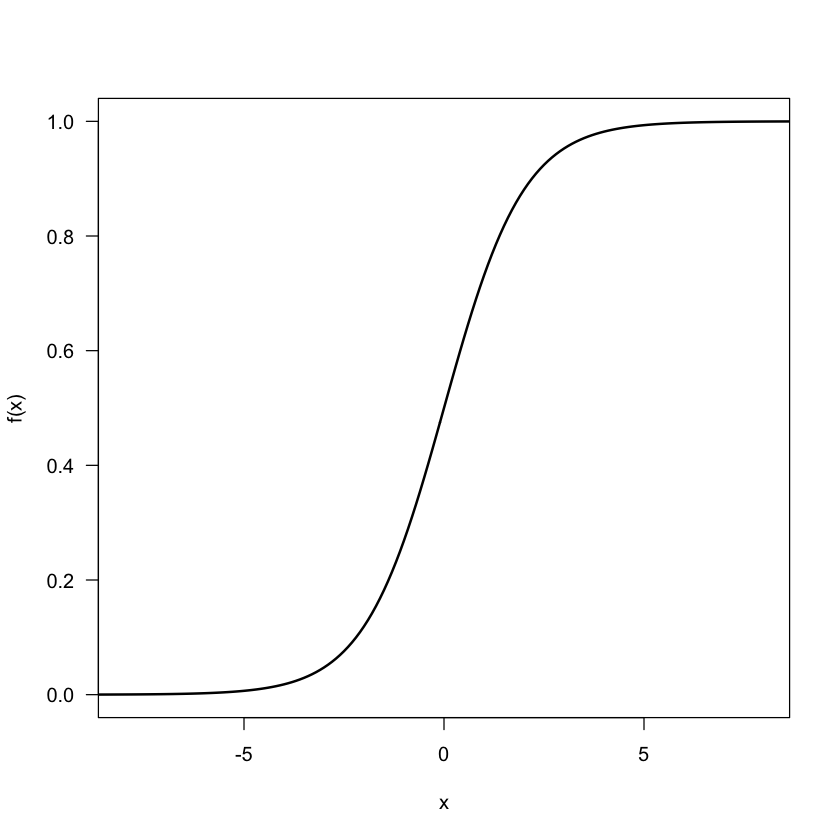

In [2]:
x = seq(-10,10,.1)
plot(x, 1/(1+exp((-1*x))), typ = 'l', 
     ylim = c(0,1), xlim = c(-8,8), 
     lwd = 2, las = 1, ylab = 'f(x)', xlab = 'x') 
 



### Now let's see how different weights affect the function

$$\begin{equation} f_{w}(x) = 1/(1+exp(-x*w)) \end{equation}$$

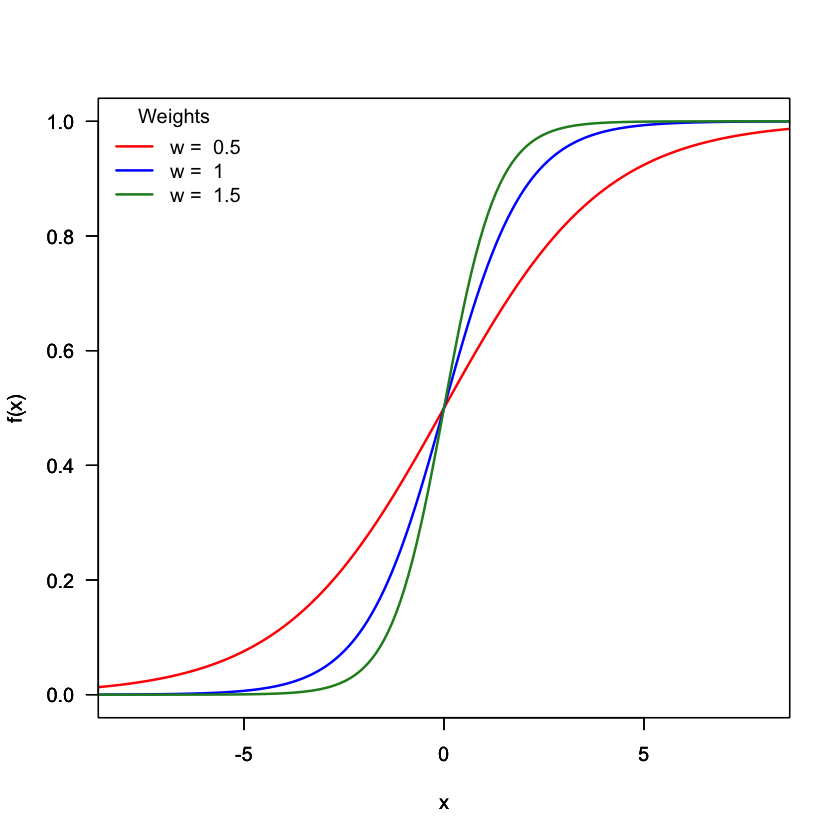

In [3]:
#make a vector of weights
w <- c(0.5,1.0,1.5)
color = c('red','blue','forestgreen')
for (i in 1:3){ 
  plot(x, 1/(1+exp((-1*x*w[i]))), 
       typ = 'l', ylim = c(0,1), xlim = c(-8,8), 
       col = color[i], lwd = 2, las = 1, ylab = 'f(x)', xlab = 'x') 
    par(new = T)
}
legend('topleft', col = color, legend = c(paste('w = ', w[1]),
                                                paste('w = ', w[2]),
                                                paste('w = ', w[3])), title = 'Weights', bty = 'n', lty = 1, lwd = 2)

### Now let's look at how biases affect the activation function

$$\begin{equation} f_{w,b}(x) = 1/(1+exp(-x*w+b)) \end{equation}$$

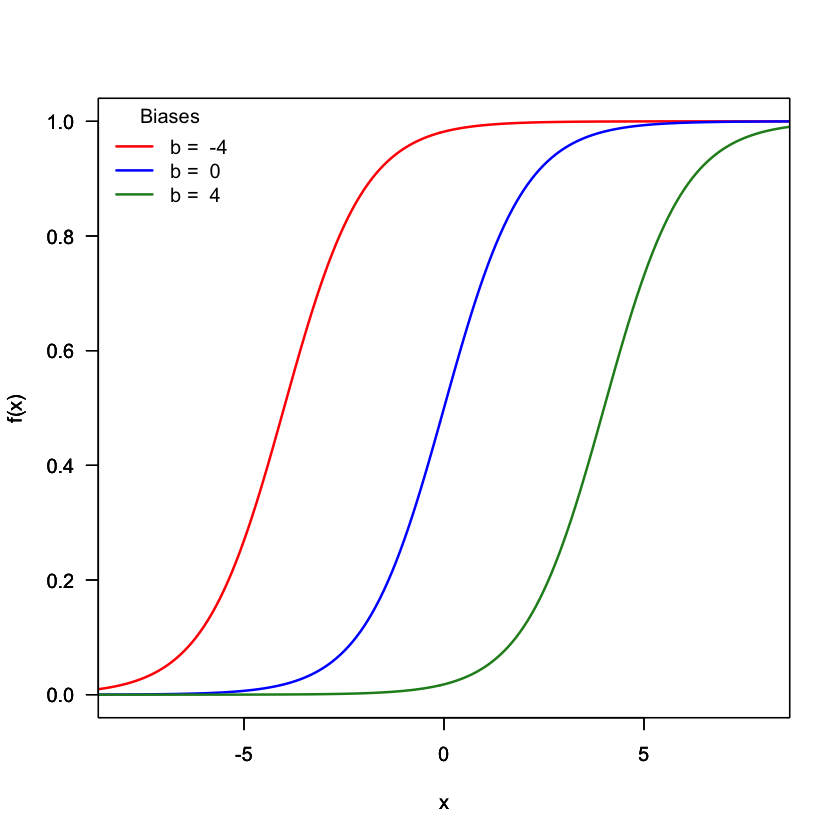

In [4]:
#make a vector of biases

b <- c(-4.0,0,4.0)
color = c('red','blue','forestgreen')
for (i in 1:3){ 
  plot(x, 1/(1+exp((-1*x*w[2]+b[i]))), 
       typ = 'l', ylim = c(0,1), xlim = c(-8,8), 
       col = color[i], lwd = 2, las = 1, ylab = 'f(x)', xlab = 'x') 
    par(new = T)
}
legend('topleft', col = color, legend = c(paste('b = ', b[1]),
                                                paste('b = ', b[2]),
                                                paste('b = ', b[3])), title = 'Biases', bty = 'n', lty = 1, lwd = 2)

### *The sigmoid function, like many functions, has two main parameters; weights (shape) and biases (location). A neural network adjusts the weights and biases of several nodes to fit the data*

# Now let's look at a concrete example

In [5]:
#this example came from: https://www.r-bloggers.com/fitting-a-neural-network-in-r-neuralnet-package/
#We will use a public dataset from R that describes housing prices around Boston
#It isn't super relavant to our work but hopefully it will be illustrative

set.seed(500)
data <- Boston

head(Boston)
# if you want to find out what all these mean go here: 
# https://www.rdocumentation.org/packages/MASS/versions/7.3-51/topics/Boston



crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


These are data about housing prices in individual suburbs of Boston
medv is the median cost of housing for a certain suburb
other columns include crime rates, zoning, average age, taxes, even measured NOx concentrations in the area

#### First let's fit a standard linear regression to the data for comparison to the neural net

In [6]:
index <- sample(1:nrow(data),round(0.75*nrow(data)))
train <- data[index,]
test <- data[-index,]
lm.fit <- glm(medv~., data=train)
pr.lm <- predict(lm.fit,test)
MSE.lm <- sum((pr.lm - test$medv)^2)/nrow(test)
#apply(scaled, 2, range)

#### Now we have to scale our data so that it ranges from 0-1
#### Next we need to split our data into a training and test data set (75%-25%)

In [7]:
maxs <- apply(data, 2, max) 
mins <- apply(data, 2, min)

scaled <- as.data.frame(scale(data, center = mins, scale = maxs - mins))

#this splits the data into a training and test set
train_ <- scaled[index,]
test_ <- scaled[-index,]


#### Run the neural net

In [8]:
n <- names(train_)

#full formula
var <- c('crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat')

#possible options for variables
#crim zn indus chas nox rm age dis rad tax ptratio black lstat
#var <- c('crim','age', 'zn')

f <- as.formula(paste("medv ~", paste(var, collapse = ' + ')))
f
nn <- neuralnet(f,data=train_,hidden=c(5,3),linear.output=T)


medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + black + lstat

#### Now let's see how the neural net did on the training data

[1] "Neural Net RMSE 15.75"
[1] "Linear Regression RMSE 21.63"


medv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + 
    tax + ptratio + black + lstat

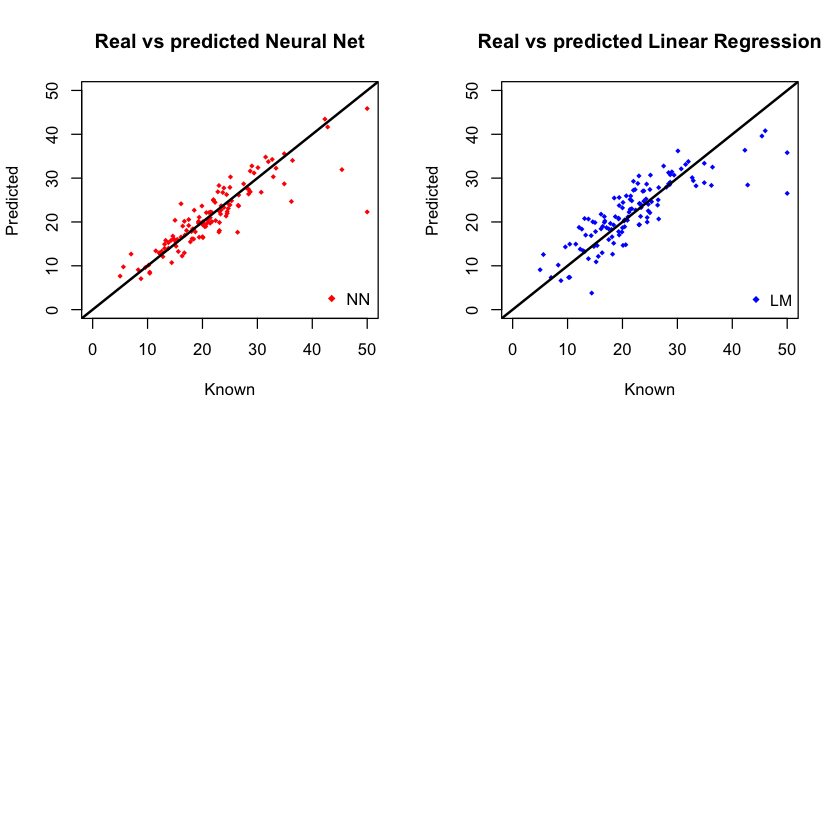

In [9]:
#using the neural net to predict
pr.nn <- compute(nn,test_[,var])
pr.nn_ <- pr.nn$net.result*(max(data$medv)-min(data$medv))+min(data$medv)
test.r <- (test_$medv)*(max(data$medv)-min(data$medv))+min(data$medv)
MSE.nn <- sum((test.r - pr.nn_)^2)/nrow(test_)

#fitting a linear regression
lm.fit <- glm(f, data=train)
pr.lm <- predict(lm.fit,test)
MSE.lm <- sum((pr.lm - test$medv)^2)/nrow(test)


#plot up the results of the validation test
par(mfrow=c(2,2))

plot(test$medv,pr.nn_,col='red',main='Real vs predicted Neural Net',pch=18,cex=0.7, ylim = c(0,50), xlim = c(0,50),
    xlab = 'Known', ylab = 'Predicted')
abline(0,1,lwd=2)
legend('bottomright',legend='NN',pch=18,col='red', bty='n')

plot(test$medv,pr.lm,col='blue',main='Real vs predicted Linear Regression',pch=18, cex=0.7, ylim = c(0,50), xlim = c(0,50),
    xlab = 'Known', ylab = 'Predicted')
abline(0,1,lwd=2)
legend('bottomright',legend='LM',pch=18,col='blue', bty='n', cex=.95)

print(paste('Neural Net RMSE',round(MSE.nn,2)))
print(paste('Linear Regression RMSE',round(MSE.lm,2)))
f


In [10]:
lapply(var, function(x) paste(x, sep = '+'))

[[1]]
[1] "crim"

[[2]]
[1] "zn"

[[3]]
[1] "indus"

[[4]]
[1] "chas"

[[5]]
[1] "nox"

[[6]]
[1] "rm"

[[7]]
[1] "age"

[[8]]
[1] "dis"

[[9]]
[1] "rad"

[[10]]
[1] "tax"

[[11]]
[1] "ptratio"

[[12]]
[1] "black"

[[13]]
[1] "lstat"